In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [ ]:
pip install --upgrade keras #installing keras 3 to get the keras sh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 18.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [ ]:
import os
import keras
from keras import layers
from keras.applications.densenet import DenseNet121

from tensorflow_docs.vis import embed

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import imageio
import cv2

In [ ]:
!wget -q https://github.com/sayakpaul/Action-Recognition-in-TensorFlow/releases/download/v1.0.0/ucf101_top5.tar.gz
!tar -xf ucf101_top5.tar.gz

In [ ]:
data_path = "/content/drive/MyDrive/Signal/ICIP training data"

classes =["0", "1", "2"]
image_folders = []
class_names = []

for class_name in classes:
  class_folder = os.path.join(data_path, class_name)
  for image_folder in os.listdir(class_folder):
    image_folder_path = os.path.join(class_folder, image_folder)
    image_folders.append(image_folder_path)
    class_names.append(class_name)

df = pd.DataFrame({
  "image_folder_path": image_folders,
  "class_name": class_names
})

df.head()


,image_folder_path,class_name
0,/content/drive/MyDrive/Signal/ICIP training da...,0
1,/content/drive/MyDrive/Signal/ICIP training da...,0
2,/content/drive/MyDrive/Signal/ICIP training da...,0
3,/content/drive/MyDrive/Signal/ICIP training da...,0
4,/content/drive/MyDrive/Signal/ICIP training da...,0


In [ ]:


from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_index in splitter.split(df, df["class_name"]):
  train_df = df.loc[train_index]
  test_df = df.loc[test_index]


In [ ]:
train_df.head()

,image_folder_path,class_name
40,/content/drive/MyDrive/Signal/ICIP training da...,0
96,/content/drive/MyDrive/Signal/ICIP training da...,2
70,/content/drive/MyDrive/Signal/ICIP training da...,1
79,/content/drive/MyDrive/Signal/ICIP training da...,2
61,/content/drive/MyDrive/Signal/ICIP training da...,1


In [ ]:
print("train Size--", len(train_df))
print("test_size--", len(test_df))

train Size-- 90
test_size-- 10


In [ ]:
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 1024
IMG_SIZE = 128

EPOCHS = 5

In [ ]:

# image = cv2.imread("/content/drive/MyDrive/Signal/ICIP training data/0/RawDataQA (1)/RawDataQA1 (1).tiff")

# # Convert the image from BGR to RGB
# image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# # Display the grayscale and RGB images
# plt.figure(figsize=(10, 7))
# plt.subplot(1, 2, 1)
# plt.imshow(image, cmap="gray")
# plt.title("Grayscale Image")
# plt.axis("off")

# plt.subplot(1, 2, 2)
# plt.imshow(image_rgb)
# plt.title("RGB Image")
# plt.axis("off")
# plt.show()


In [ ]:
# def load_video(path, max_frames=0, offload_to_cpu=False):
#     img_paths = [os.path.join(path,pt) for pt in os.listdir(path)]
#     i = 0
#     frames = []

#     while i < len(img_paths):
#         frame = cv2.imread(img_paths[i])

#         frame = frame[:, :, [2, 1, 0]]
#         frame = crop_center(frame)
#         if offload_to_cpu and keras.backend.backend() == "torch":
#             frame = frame.to("cpu")
#         frames.append(frame)
#         i += 1
#         if i == max_frames:
#             break


#     if offload_to_cpu and keras.backend.backend() == "torch":
#         return np.array([frame.to("cpu").numpy() for frame in frames])
#     return np.array(frames)

# arr = load_video("/content/drive/MyDrive/Signal/ICIP training data/0/RawDataQA (1)", max_frames=10)
# arr.shape

In [ ]:

print(f"Total patients for training: {len(train_df)}")
print(f"Total  for testing: {len(test_df)}")

center_crop_layer = layers.CenterCrop(IMG_SIZE, IMG_SIZE)


def crop_center(frame):
    cropped = center_crop_layer(frame[None, ...])
    cropped = keras.ops.convert_to_numpy(cropped)
    cropped = keras.ops.squeeze(cropped)
    return cropped



def load_video(path, max_frames=0, offload_to_cpu=False):
    img_paths = [os.path.join(path,pt) for pt in os.listdir(path)]
    i = 0
    frames = []

    while i < len(img_paths):
        frame = cv2.imread(img_paths[i])

        frame = frame[:, :, [2, 1, 0]]
        frame = crop_center(frame)
        if offload_to_cpu and keras.backend.backend() == "torch":
            frame = frame.to("cpu")
        frames.append(frame)
        i += 1
        if i == max_frames:
            break


    if offload_to_cpu and keras.backend.backend() == "torch":
        return np.array([frame.to("cpu").numpy() for frame in frames])
    return np.array(frames)


def build_feature_extractor():
    feature_extractor = DenseNet121(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.densenet.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()


# Label preprocessing with StringLookup.
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["class_name"]), mask_token=None
)
print(label_processor.get_vocabulary())


def prepare_all_videos(df):
    num_samples = len(df)
    video_paths = df["image_folder_path"].values.tolist()
    labels = df["class_name"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_features` are what we will feed to our sequence model.
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(path,MAX_SEQ_LENGTH)

        # Pad shorter videos.
        if len(frames) < MAX_SEQ_LENGTH:
            diff = MAX_SEQ_LENGTH - len(frames)
            padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
            frames = np.concatenate(frames, padding)

        frames = frames[None, ...]

        # Initialize placeholder to store the features of the current video.
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                if np.mean(batch[j, :]) > 0.0:
                    temp_frame_features[i, j, :] = feature_extractor.predict(
                        batch[None, j, :]
                    )

                else:
                    temp_frame_features[i, j, :] = 0.0

        frame_features[idx,] = temp_frame_features.squeeze()

    return frame_features, labels

Total patients for training: 90
Total  for testing: 10
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
['0', '1', '2']


In [ ]:
test_data, test_labels = prepare_all_videos(test_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━

In [ ]:
train_data, train_labels = prepare_all_videos(train_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1

In [ ]:
test_data.shape

(10, 20, 1024)

In [ ]:
# train_data, train_labels = np.load("train_data.npy"), np.load("train_labels.npy")
# test_data, test_labels = np.load("test_data.npy"), np.load("test_labels.npy")

# print(f"Frame features in train set: {train_data.shape}")

Frame features in train set: (594, 20, 1024)


In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def build(self, input_shape):
        self.position_embeddings.build(input_shape)

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        inputs = keras.ops.cast(inputs, self.compute_dtype)
        length = keras.ops.shape(inputs)[1]
        positions = keras.ops.arange(start=0, stop=length, step=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions


class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation=keras.activations.gelu),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

In [ ]:
def get_compiled_model(shape):
    sequence_length = MAX_SEQ_LENGTH
    embed_dim = NUM_FEATURES
    dense_dim = 4
    num_heads = 1
    classes = len(label_processor.get_vocabulary())

    inputs = keras.Input(shape=shape)
    x = PositionalEmbedding(
        sequence_length, embed_dim, name="frame_position_embedding"
    )(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


def run_experiment():
    filepath = "/tmp/video_classifier.weights.h5"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    model = get_compiled_model(train_data.shape[1:])
    history = model.fit(
        train_data,
        train_labels,
        validation_split=0.15,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    model.load_weights(filepath)
    _, accuracy = model.evaluate(test_data, test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return model

In [ ]:
trained_model = run_experiment()

Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4076 - loss: 2.6591
Epoch 1: val_loss improved from inf to 0.97743, saving model to /tmp/video_classifier.weights.h5
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.4044 - loss: 2.7672 - val_accuracy: 0.7857 - val_loss: 0.9774
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5748 - loss: 1.6370
Epoch 2: val_loss did not improve from 0.97743
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5693 - loss: 1.6622 - val_accuracy: 0.6429 - val_loss: 1.4083
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.6365 - loss: 1.2526
Epoch 3: val_loss did not improve from 0.97743
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 734ms/step - accuracy: 0.6188 - loss: 1.3284 - val_accuracy: 0.6429 - val_loss: 1.5853
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - accuracy: 0.4723 - loss: 1.6590
Epoch 4: val_loss did not improve from 0.97743
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 765ms/step - accuracy: 0.4858 - loss: 1.6143 - val_accuracy: 0.7857 -

In [ ]:

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

y_pred = trained_model.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_labels

precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
sensitivity = recall
specificity = 1 - np.diag(confusion_matrix(y_true, y_pred)) / np.sum(confusion_matrix(y_true, y_pred), axis=1)

print("Precision:", precision)
print("Recall:", recall)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("F1 Score:", fscore)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Precision: 0.85
Recall: 0.7777777777777777
Sensitivity: 0.7777777777777777
Specificity: [0.         0.66666667 0.        ]
F1 Score: 0.7486772486772487


Test video path: /content/drive/MyDrive/Signal/ICIP training data/0/RawDataQA (10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
  0: 90.03%
  1:  7.78%
  2:  2.19%


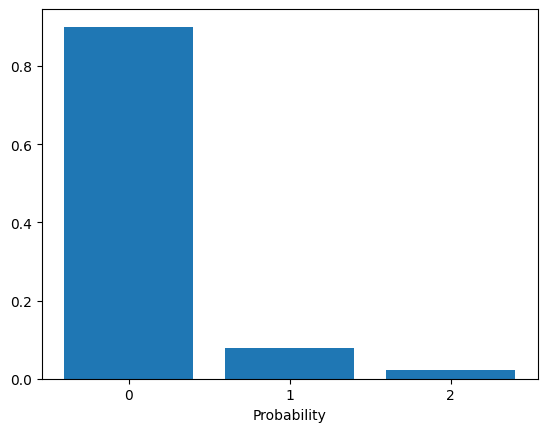


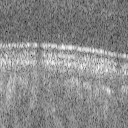

In [ ]:
def prepare_single_video(frames):
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    # Pad shorter videos.
    if len(frames) < MAX_SEQ_LENGTH:
        diff = MAX_SEQ_LENGTH - len(frames)
        padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
        frames = np.concatenate(frames, padding)

    frames = frames[None, ...]

    # Extract features from the frames of the current video.
    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            if np.mean(batch[j, :]) > 0.0:
                frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
            else:
                frame_features[i, j, :] = 0.0

    return frame_features


def predict_action(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(path)
    frame_features = prepare_single_video(frames)
    probabilities = trained_model.predict(frame_features)[0]

    plot_x_axis, plot_y_axis = [], []

    for i in np.argsort(probabilities)[::-1]:
        plot_x_axis.append(class_vocab[i])
        plot_y_axis.append(probabilities[i])
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")

    plt.bar(plot_x_axis, plot_y_axis, label=plot_x_axis)
    plt.xlabel("class_label")
    plt.xlabel("Probability")
    plt.show()

    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = "/content/drive/MyDrive/Signal/ICIP training data/0/RawDataQA (10)"
print(f"Test video path: {test_video}")
test_frames = predict_action(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])
#mekanm hari naikwa balanna one